<a href="https://colab.research.google.com/github/mozarik/solo-bolo-ML/blob/main/tugas_lms/Tugas_3_Klasifikasi_ANNAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Tugas 3 - Klasifikasi ANN Assignment

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [4]:
!kaggle datasets download --unzip -d alxmamaev/flowers-recognition

 99% 222M/225M [00:01<00:00, 142MB/s]
100% 225M/225M [00:01<00:00, 136MB/s]


In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
import cv2
from tqdm import tqdm
import random as rn

import os
print(os.listdir("flowers"))

['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']


In [45]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [49]:
#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [10]:
daisy_path = "flowers/daisy/"
tulip_path = "flowers/tulip/" 

In [11]:
trainLabels = [] # For labels. Daisy and tulip
data = [] # All image array

# Dimensions of the images are not fixed. They have various sizes and we will fix tham to 128x128
size = 128,128

def readImages(flowerPath, folder):
    
    imagePaths = []
    for file in os.listdir(flowerPath):
        if file.endswith("jpg"):  # use only .jpg extensions
            imagePaths.append(flowerPath + file)
            trainLabels.append(folder)
            img = cv2.imread((flowerPath + file), 0)
            im = cv2.resize(img, size)
            data.append(im)            
            
    return imagePaths

In [12]:
def showImage(imgPath):
    img = cv2.imread(imgPath)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis('off')
    plt.show()

In [13]:
daisyPaths = readImages(daisy_path, 'daisy')
tulipPaths = readImages(tulip_path, 'tulip')

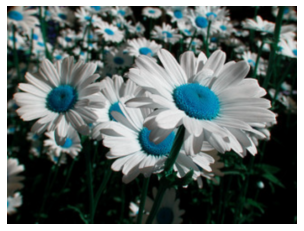

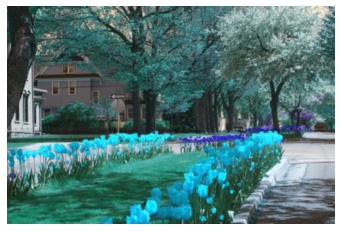

In [14]:
showImage(daisyPaths[np.random.randint(0,500)])
showImage(tulipPaths[np.random.randint(0,500)])

In [18]:
rawData = np.array(data)
rawData.shape

(1748, 128, 128)

In [16]:
rawData = rawData.astype('float32') / 255.0

In [20]:
X = rawData
z = np.zeros(874)
o = np.ones(874)
Y = np.concatenate((z, o), axis = 0).reshape(X.shape[0], 1)

print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (1748, 128, 128)
Y shape:  (1748, 1)


In [21]:
# Let's create train and test data
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.15, random_state = 42)
numberOfTrain = xTrain.shape[0]
numberOfTest = xTest.shape[0]

In [22]:
# Transforming data to 2D.

xTrainFlatten = xTrain.reshape(numberOfTrain, xTrain.shape[1] * xTrain.shape[2])
xTestFlatten = xTest.reshape(numberOfTest, xTest.shape[1] * xTest.shape[2])

print("X train flatten", xTrainFlatten.shape)
print("X test flatten", xTestFlatten.shape)

X train flatten (1485, 16384)
X test flatten (263, 16384)


In [23]:
x_train = xTrainFlatten.T
x_test = xTestFlatten.T
y_train = yTrain.T
y_test = yTest.T
print("x train: ",xTrain.shape)
print("x test: ",xTest.shape)
print("y train: ",yTrain.shape)
print("y test: ",yTest.shape)

x train:  (1485, 128, 128)
x test:  (263, 128, 128)
y train:  (1485, 1)
y test:  (263, 1)


In [24]:
def initializeParametersAndLayerSizesNN(x_train, y_train):
    
    parameters = {"weight1": np.random.randn(3, x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((3, 1)),
                  "weight2": np.random.randn(y_train.shape[0], 3) * 0.1,
                  "bias2": np.zeros((y_train.shape[0], 1))}
    
    return parameters

In [25]:
# Method for sigmoid function
# z = np.dot(w.T, x_train) + b
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [26]:
def forwardPropagationNN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"], x_train) + parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"], A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [27]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [29]:
# Buat model dengan 1 input layer, 1 hidden layer, dan 1 output layer
img_input = layers.Input(shape=(128, 128, 3)) # layer input
x = layers.Flatten()(img_input) # ubah dari matriks 150x150x3 menjadi vektor
x = layers.Dense(128, activation='relu')(x) # hidden layer 1 dengan 128 neuron
output = layers.Dense(1, activation='sigmoid')(x) # output layer dengan 1 neuron (binary)

# Definisikan modelnya
model = Model(img_input, output)

In [30]:
from tensorflow.keras.optimizers import Adam

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
H = model.fit(x_train, y_train, batch_size=20, epochs=50, validation_data=(x_test, y_test))

ValueError: ignored

In [33]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
# FLOWER_TULIP_DIR='../input/flowers-recognition/flowers/tulip'
#FLOWER_DANDI_DIR='../input/flowers-recognition/flowers/dandelion'
# FLOWER_ROSE_DIR='../input/flowers-recognition/flowers/rose'

In [34]:
def assign_label(img,flower_type):
    return flower_type

In [35]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))  

In [38]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:02<00:00, 377.53it/s]

764


In [39]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:02<00:00, 310.72it/s]

1497


In [40]:
print(len(X))
print(len(Z))
print(set(Z))

1497
1497
{'Daisy', 'Sunflower'}


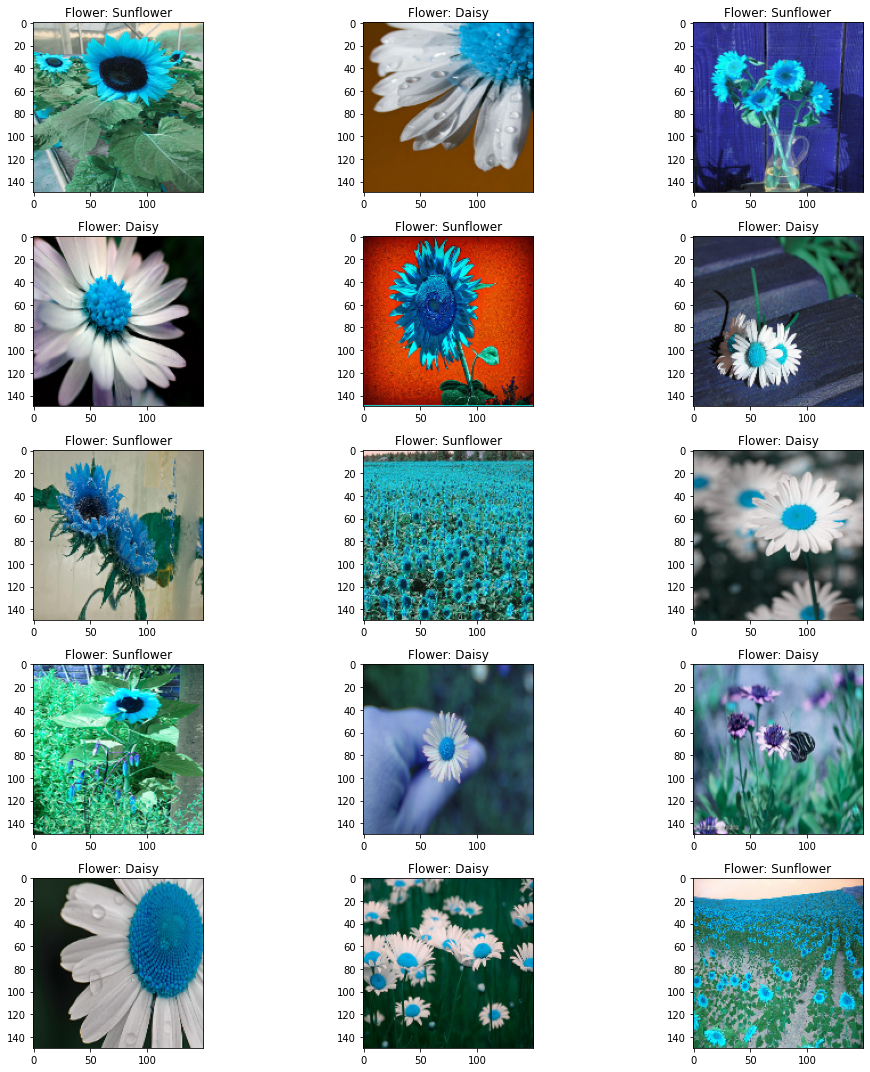

In [43]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout();

In [50]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y.shape)

(1497, 2)


In [51]:
print(type(X))
print(len(X))
print(X[1].shape)

<class 'list'>
1497
(150, 150, 3)


In [52]:
X_NEW=np.array(X)
# Image Standardization [Scale 0-1]
X_NEW=X_NEW/255

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X_NEW,Y,test_size=0.20,random_state=42)

In [54]:
np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test)

((1197, 150, 150, 3), (1197, 2), (300, 150, 150, 3), (300, 2))

In [56]:
import tensorflow as tf 

In [63]:
# Buat model dengan 1 input layer, 1 hidden layer, dan 1 output layer
img_input = layers.Input(shape=(150, 150, 3)) # layer input
x = layers.Flatten()(img_input) # ubah dari matriks 150x150x3 menjadi vektor
x = layers.Dense(128, activation='relu')(x) # hidden layer 1 dengan 128 neuron
output = layers.Dense(2, activation='sigmoid')(x) # output layer dengan 1 neuron (binary)

# Definisikan modelnya
model = Model(img_input, output)

In [64]:
from tensorflow.keras.optimizers import Adam

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
batchSize=256
ep=50
H= model.fit(X_train,y_train,batch_size=batchSize,epochs=ep,validation_split=.15)

Epoch 1/50
4/4 [==============================] - 1s 253ms/step - loss: 0.2703 - acc: 0.8810 - val_loss: 0.5270 - val_acc: 0.8167
Epoch 2/50
4/4 [==============================] - 1s 225ms/step - loss: 0.2651 - acc: 0.8830 - val_loss: 0.5333 - val_acc: 0.8111
Epoch 3/50
4/4 [==============================] - 1s 222ms/step - loss: 0.2607 - acc: 0.8879 - val_loss: 0.5290 - val_acc: 0.8167
Epoch 4/50
4/4 [==============================] - 1s 221ms/step - loss: 0.2523 - acc: 0.8928 - val_loss: 0.5247 - val_acc: 0.8222
Epoch 5/50
4/4 [==============================] - 1s 219ms/step - loss: 0.2470 - acc: 0.8958 - val_loss: 0.5186 - val_acc: 0.8222
Epoch 6/50
4/4 [==============================] - 1s 220ms/step - loss: 0.2408 - acc: 0.9027 - val_loss: 0.5376 - val_acc: 0.8278
Epoch 7/50
4/4 [==============================] - 1s 222ms/step - loss: 0.2323 - acc: 0.9066 - val_loss: 0.5449 - val_acc: 0.8278
Epoch 8/50
4/4 [==============================] - 1s 220ms/step - loss: 0.2261 - acc: 0.90

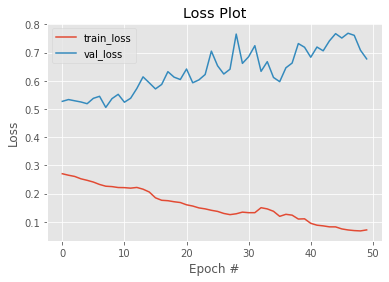

In [69]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

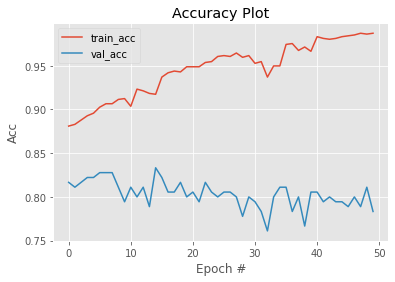

In [70]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import classification_report

pred = model.predict(X_test)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       142
           1       0.80      0.83      0.82       158

   micro avg       0.81      0.80      0.80       300
   macro avg       0.81      0.80      0.80       300
weighted avg       0.81      0.80      0.80       300
 samples avg       0.80      0.80      0.80       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
